In [1]:
using RxInfer
using GraphViz

using Test
using TOML
using BenchmarkTools
using VBMC

using Distributions
using Random
using StatsBase
using LogarithmicNumbers

Random.seed!(1234)
if "test" in readdir()
    cd("test")
end

[ Info: Precompiling VBMC [1064e537-9ee1-43d8-887b-42e480a72de7] (cache misses: include_dependency fsize change (2), mismatched flags (16))


In [2]:
vars = TOML.parsefile("Constants.toml")
T, U, X, Y = vars["T"], vars["U"], vars["X"], vars["Y"]
@test T == 10 && U == 3 && X == 2

P1 = begin
    Vector(1:U*X) |>
    Dirichlet |>
    rand |>
    (x -> Categorical(x)) |>
    (d -> ReshapedCategorical(d, U, X))
end

#P(·,· | u_prev, x_prev) = Pt[:,:,u_prev,x_prev] sums to 1 for fixed u_prev, x_prev
Pt = reshape(rand(Dirichlet(1:U*X), U * X), (U, X, U, X)) |> TransitionDistribution

function emissionf(randVal, u, x)
    randVal .+ x
end
function revf(emission, u, x)
    emission .- x
end #the dot vectorizes, could use X instead
emission = Emission(emissionf, revf)

Pe = EmissionDistribution{Continuous}(Normal(0, 1), emission, U, X)
dist = HpmmDistribution(P1, Pt, Pe)
hpmm = rand(dist, T)

TMM([2, 3, 3, 3, 2, 1, 1, 3, 1, 1], [1, 2, 2, 1, 2, 2, 2, 2, 2, 2], Real[0.30310856531062125, 4.005922892438383, 2.416114351269989, 0.43389113275540614, 4.962020376658801, 1.3634312189577709, 2.48076349099979, 2.197399617131897, 3.237766451553191, 0.6280368894524171])

In [3]:
A = reshape(Pt.mat, U*X, U*X)

6×6 Matrix{Float64}:
 0.0775709  0.134356   0.0167945  0.0435918  0.0179353  0.0169969
 0.083756   0.0875991  0.199748   0.149008   0.115934   0.173053
 0.0933412  0.255101   0.34729    0.199728   0.144115   0.238636
 0.106916   0.0625408  0.0732044  0.193992   0.154473   0.229528
 0.248786   0.141594   0.152717   0.213589   0.245022   0.0988651
 0.38963    0.318809   0.210245   0.200092   0.322521   0.242921

In [4]:
function get_x(w)
    VBMC.reshapeindex(w, U, X)[2]
end
function get_u(w)
    VBMC.reshapeindex(w, U, X)[1]
end

# struct Start{T <: Real} <:  DiscreteMultivariateDistribution
#     w :: AbstractArray{T}
#     y :: T
# end

struct MarkovTransition{T <: Real} <: DiscreteMultivariateDistribution
    wpast :: AbstractArray{T}
    wt :: AbstractArray{T}
    y :: T
end

# @node Start Stochastic [w, y]

@node MarkovTransition Stochastic [wt, wpast, y]

#rules towards y
@rule MarkovTransition(:y, Marginalisation) (q_wpast :: Categorical, q_wt :: Categorical) = PointMass(y)

#rules towards w_past
@rule MarkovTransition(:wpast, Marginalisation) (q_y :: PointMass, q_wt :: Categorical) = begin
    G = q_wt.p
    A = Pt.mat
    ηs = exp(log(A)' * G)
    νs = ηs ./ sum(ηs)
    return Categorical(νs...)
end

#rules towards w_t
@rule MarkovTransition(:wt, Marginalisation) (q_y :: PointMass, q_wpast :: Categorical) = begin
    F = q_wpast.p
    A = Pt.mat
    B = 1:length(q_w.p) .|> w -> pdf(Normal(0,1), q_y.point-get_x(w))
    ηs = exp.(log.(A) * F) .* B # | clamp(⋅,tiny,one) | exp maybe or smth?
    νs = ηs ./ sum(ηs)
    return Categorical(νs...)
end


@marginalrule MarkovTransition(:wt_wpast_y) (q_wt::Categorical, q_wpast::Categorical, q_y::PointMass) = begin
    F = q_wpast.p
    A = Pt.mat
    B = 1:length(q_w.p) .|> w -> pdf(Normal(0,1), q_y.point-get_x(w))
    ηs = exp.(log.(A) * F) .* B
    
    G = q_wt.p
    ps = ηs .* G
    ps = ps ./ sum(ps)

    return (wt = Categorical(ps...), wpast = q_wpast, y = q_y) #leave q_wpast as is?
end

@average_energy MarkovTransition (q_y::PointMass, q_wpast::Categorical, q_wt::Categorical) = begin
    A = Pt.mat
    B = 1:length(q_w.p) .|> w -> pdf(Normal(0,1), q_y.point-get_x(w))
    G, F = q_wpast.p, q_wt.p

    #<E(wt | w_prevt)>_q_prewt,q_wt + <E(y | wt)>_q_y,q_wt
    #F' * ln A * G + (ln B)' * F ish
    F' * log.(A) * G + log.(B)' * F
end

In [5]:
using RxInfer
B = 1:U*X .|> w -> pdf(Normal(0,1), hpmm.Y[1]-get_x(w))
p1 = P1.d.p .* B
p1 = p1./sum(p1)
p1 = round.(p1,digits=3)

@model function hidden_markov_model(y, T)
    wpast ~ Categorical(p1)
    wt ~ MarkovTransition(wpast, y[2]) 
    # w[3] ~ MarkovTransition(w[2], y[3]) 
end

@model function hidden_markov_model(y, T)
    wpast ~ Categorical(p1)
    wt ~ MarkovTransition(wpast) 
    y[2] ~ EmissionNode(wt)
    # w[3] ~ MarkovTransition(w[2], y[3]) 
end

In [6]:
model_generator = hidden_markov_model() | (y = hpmm.Y[1:2], T = 2)
model_to_plot = RxInfer.getmodel(RxInfer.create_model(model_generator))
GraphViz.load(model_to_plot, strategy = :simple, layout="dot", width=5.,height=5.)

LoadError: `MarkovTransition` has `2` input interfaces `(:wpast, :y)`, but `1` arguments provided.

In [16]:
model_to_plot

GraphPPL.Model{MetaGraphsNext.MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend{Static.False}, String}(Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, Main.hidden_markov_model, "", nothing, {Categorical{P} where P<:Real = 1, MarkovTransition = 1}, {}, {(Categorical{P} where P<:Real, 1) = Categorical{P} where P<:Real_3, (MarkovTransition, 1) = MarkovTransition_6}, {:wt = wt_4, :wpast = wpast_1, :constvar_2 = constvar_2}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[#undef, y_5])}, {}, {}, Base.RefValue{Any}(wt_4)), and default weight 1.0, GraphPPL.PluginsCollection{Tuple{}}(()), RxInfer.ReactiveMP

In [17]:
GraphPPL.variable_nodes(model_to_plot)

Base.Iterators.Filter{GraphPPL.var"#40#41"{GraphPPL.Model{MetaGraphsNext.MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend{Static.False}, String}}, Base.Generator{Base.OneTo{Int64}, MetaGraphsNext.var"#20#21"{MetaGraphsNext.MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}}}}(GraphPPL.var"#40#41"{GraphPPL.Model{MetaGraphsNext.MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend{Static.False}, String}}(GraphPPL.Model{MetaGraphsNext.MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.N

In [13]:
a = infer(
    model = hidden_markov_model(),
    # constraints = hidden_markov_constraints,
    data = (y = hpmm.Y[1:2],T=2),
    options = (limit_stack_depth = 500,),
    free_energy = true,
    showprogress=true,
    iterations = 2,    
    callbacks = (
        on_marginal_update = (model, name, update) -> println("$(name) has been updated: $(update)"),
    )
)

LoadError: Half-edge has been found: wt_4. To terminate half-edges 'Uninformative' node can be used.

In [39]:
A = reshape(Pt.mat, U*X, U*X)
lnA = log.(A)
qpast = Categorical(U*X).p
lnA * qpast

6-element Vector{Float64}:
 -3.0861022542913177
 -2.463481614860057
 -1.8543946226945307
 -1.7368137675940374
 -1.5487123696438576
 -1.5710621015038633

In [42]:
lnA

6×6 Matrix{Float64}:
 -3.14162  -2.09949  -3.5893   -4.35421  -1.7042    -3.62779
 -2.67286  -2.54201  -2.63866  -1.45322  -2.40575   -3.06837
 -1.74954  -2.19569  -1.71553  -3.31184  -0.967687  -1.18607
 -1.71908  -1.83874  -1.87132  -1.37859  -2.47359   -1.13955
 -1.35841  -1.06659  -1.24505  -1.59103  -2.20078   -1.83041
 -1.28165  -1.69121  -1.27579  -1.34234  -1.8778    -1.95759

# Rényi divergence

Paneme tähele, et hiljem saaks parandada variatsioonilist mõõtu q, peame me rakendama Jenseni võrratust, aga seda saab teha vaid kumerate funktsioonidega. alpha <1 ei pruugi olla kumer.

In [68]:
N = 4
function D_half(q, p)
    sum = 0
    for i in 1:N
        sum += sqrt(q[i] * p[i])
    end
    -2*log(sum)
end

function D_inf(q, p)
    best = -Inf
    for i in 1:N
        ratio = q[i]/p[i]
        if ratio > best
            best = ratio
        end
    end
    best
end

function D_alpha(alpha, q, p)
    sum = 0
    for i in 1:N
        sum += q[i]^alpha / p[i]^(alpha-1)
    end
    1/(alpha-1) * log(sum)
end

D_alpha (generic function with 1 method)

In [83]:
q = [1/4, 1/4, 1/4, 1/4]
p = [1/20, 9/20, 11/20, 1/20];

In [124]:
alpha = 0.3

0.3

In [125]:
D_alpha(alpha, [0.01,0.01,0.97,0.01], p) / D_alpha(alpha, [0.01,0.97,0.1,0.01], p)

3.595553277777912

In [ ]:
f = alpha -> D_alpha(alpha, [0.01,0.3,0.95,0.01], p) / D_alpha(alpha, [0.01,0.95,0.3,0.01], p)

#212 (generic function with 1 method)

In [103]:
D_alpha(alpha, q, p)

-0.09136265829790435

In [61]:
D_inf(p, p)

1.0

In [62]:
D_inf([0, 1, 0, 0], p)

2.0

In [63]:
D_inf(q, p)

2.0

In [111]:
using Plots

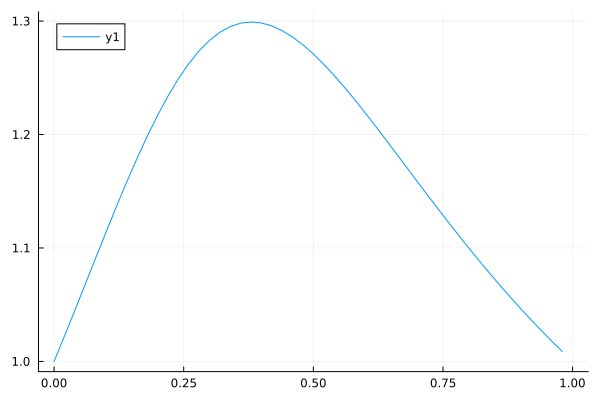

In [114]:
plot(f, 0:0.02:1) 

In [ ]:
a = infer(
    model = hidden_markov_model(),
    constraints = hidden_markov_constraints,
    initialization = init,
    data = (y = hpmm.Y[1:T],),
    options = (limit_stack_depth = 500,),
    free_energy = true,
    showprogress=true,
    iterations = 20,    
    warn = false,
    callbacks = (
        on_marginal_update = (model, name, update) -> begin
            open("txts/$(string(time()-base_time)).txt","a") do io
                println(io,"$(update)")
            end
        end,
    )
)

model_generator = hidden_markov_model() | (y = hpmm.Y,)
model_to_plot = RxInfer.getmodel(RxInfer.create_model(model_generator))
GraphViz.load(model_to_plot, strategy = :simple, layout="dot", width=5.,height=5.)